Plug-and-Play FISTA Demosaicing
===============================

This example demonstrates the use of class [fista.ppp.PPP](http://sporco.rtfd.org/en/latest/modules/sporco.fista.ppp.html#sporco.fista.ppp.PPP) for solving a raw image demosaicing problem via the FISTA Plug and Play Priors (PPP) algorithm [[24]](http://sporco.rtfd.org/en/latest/zreferences.html#kamilov-2017-plugandplay).

In [1]:
from __future__ import print_function
from builtins import input, range

import numpy as np

from bm3d import bm3d_rgb

from sporco.fista.ppp import PPP
from sporco.interp import bilinear_demosaic
from sporco import metric
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Define demosaicing forward operator and its transpose.

In [2]:
def A(x):
    """Map an RGB image to a single channel image with each pixel
    representing a single colour according to the colour filter array.
    """

    y = np.zeros(x.shape[0:2])
    y[1::2, 1::2] = x[1::2, 1::2, 0]
    y[0::2, 1::2] = x[0::2, 1::2, 1]
    y[1::2, 0::2] = x[1::2, 0::2, 1]
    y[0::2, 0::2] = x[0::2, 0::2, 2]
    return y


def AT(x):
    """Back project a single channel raw image to an RGB image with zeros
    at the locations of undefined samples.
    """

    y = np.zeros(x.shape + (3,))
    y[1::2, 1::2, 0] = x[1::2, 1::2]
    y[0::2, 1::2, 1] = x[0::2, 1::2]
    y[1::2, 0::2, 1] = x[1::2, 0::2]
    y[0::2, 0::2, 2] = x[0::2, 0::2]
    return y

Load reference image.

In [3]:
img = util.ExampleImages().image('kodim23.png', scaled=True,
                                 idxexp=np.s_[160:416,60:316])

Construct test image constructed by colour filter array sampling and adding Gaussian white noise.

In [4]:
np.random.seed(12345)
s = A(img)
rgbshp = s.shape + (3,)  # Shape of reconstructed RGB image
rgbsz = s.size * 3       # Size of reconstructed RGB image
nsigma = 2e-2            # Noise standard deviation
sn = s + nsigma * np.random.randn(*s.shape)

Define data fidelity term for PPP problem.

In [5]:
def f(x):
    return 0.5 * np.linalg.norm((A(x) - sn).ravel())**2

Define gradient of data fidelity term for PPP problem.

In [6]:
def gradf(x):
    return AT(A(x) - sn)

Define proximal operator of (implicit, unknown) regularisation term for PPP problem. In this case we use BM3D [[12]](http://sporco.rtfd.org/en/latest/zreferences.html#dabov-2008-image) as the denoiser, using the [code](https://pypi.org/project/bm3d) released with [[28]](http://sporco.rtfd.org/en/latest/zreferences.html#makinen-2019-exact).

In [7]:
bsigma = 3.3e-2  # Denoiser parameter

def proxg(x, L):
    return bm3d_rgb(x, bsigma)

Construct a baseline solution and initaliser for the PPP solution by BM3D denoising of a simple bilinear demosaicing solution. The `3 * nsigma` denoising parameter for BM3D is chosen empirically for best performance.

In [8]:
imgb = bm3d_rgb(bilinear_demosaic(sn), 3 * nsigma)

Set algorithm options for PPP solver, including use of bilinear demosaiced solution as an initial solution.

In [9]:
opt = PPP.Options({'Verbose': True, 'RelStopTol': 1e-3,
                   'MaxMainIter': 20, 'L': 6.8e-1, 'X0': imgb})

Create solver object and solve, returning the the demosaiced image ``imgp``.

In [10]:
b = PPP(img.shape, f, gradf, proxg, opt=opt)
imgp = b.solve()

Itn   FVal      Rsdl    
------------------------


   0  1.53e+01  4.52e+00


   1  1.69e+01  2.62e+00


   2  1.45e+01  2.42e+00


   3  1.46e+01  1.89e+00


   4  1.36e+01  1.79e+00


   5  1.37e+01  1.38e+00


   6  1.34e+01  1.28e+00


   7  1.36e+01  1.18e+00


   8  1.35e+01  1.20e+00


   9  1.36e+01  1.26e+00


  10  1.35e+01  1.35e+00


  11  1.37e+01  1.39e+00


  12  1.35e+01  1.42e+00


  13  1.36e+01  1.30e+00


  14  1.35e+01  1.26e+00


  15  1.36e+01  1.17e+00


  16  1.35e+01  1.26e+00


  17  1.36e+01  1.31e+00


  18  1.35e+01  1.41e+00


  19  1.36e+01  1.54e+00
------------------------


Display solve time and demosaicing performance.

In [11]:
print("PPP FISTA solve time:       %5.2f s" % b.timer.elapsed('solve'))
print("Bilinear demosaicing PSNR:  %5.2f dB" % metric.psnr(img, imgb))
print("PPP demosaicing PSNR:       %5.2f dB" % metric.psnr(img, imgp))

PPP FISTA solve time:       87.84 s
Bilinear demosaicing PSNR:  30.66 dB
PPP demosaicing PSNR:       36.51 dB


Display reference and demosaiced images.

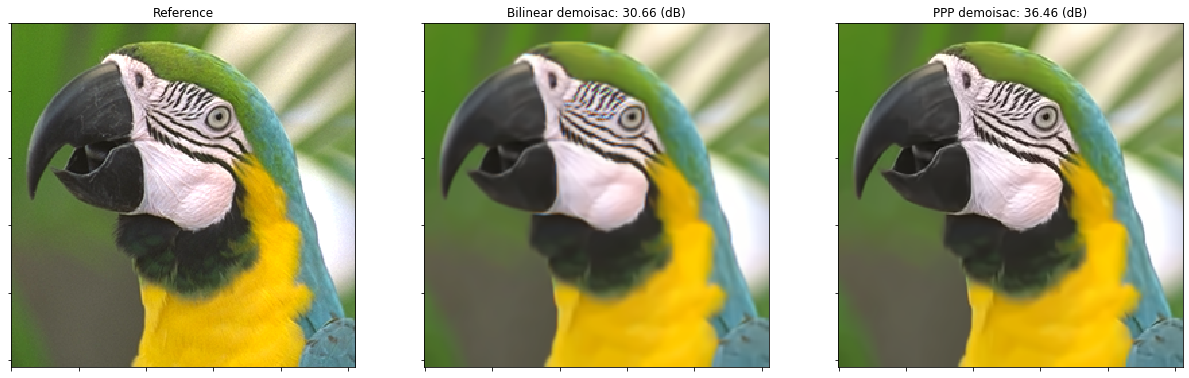

In [12]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True,
                        figsize=(21, 7))
plot.imview(img, title='Reference', fig=fig, ax=ax[0])
plot.imview(imgb, title='Bilinear demoisac: %.2f (dB)' %
            metric.psnr(img, imgb), fig=fig, ax=ax[1])
plot.imview(imgp, title='PPP demoisac: %.2f (dB)' %
            metric.psnr(img, imgp), fig=fig, ax=ax[2])
fig.show()